# Milestone 1: Preparing Time Series Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
df = pd.read_csv("workflow_files/data/sales.csv")

In [4]:
df.head()

,date,store_id,cat_id,sales
0,2011-01-29,TX_1,FOODS,3950.35
1,2011-01-30,TX_1,FOODS,3844.97
2,2011-01-31,TX_1,FOODS,2888.03
3,2011-02-01,TX_1,FOODS,3631.28
4,2011-02-02,TX_1,FOODS,3072.18


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58230 entries, 0 to 58229
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      58230 non-null  object 
 1   store_id  58230 non-null  object 
 2   cat_id    58230 non-null  object 
 3   sales     58230 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.8+ MB


In [6]:
print(df['store_id'].nunique())
print(df['cat_id'].nunique())
df.describe()

10
3


,sales
count,58230.000000
mean,3290.014529
std,2452.281668
min,0.000000
25%,1342.247500
50%,2578.125000
75%,4641.092500
max,16737.820000


The range of sales is is 0 (min) to 16737.82 (max). For the range of dates we need to convert the dates from string to a datetime format.

In [7]:
df['date_format'] = pd.to_datetime(df['date'])
df['date_format'].min()

Timestamp('2011-01-29 00:00:00')

In [8]:
df['date_format'].max()

Timestamp('2016-05-22 00:00:00')

So this new column is showing as a Series of datetime objects.

In [9]:
# Checking for duplicates

# By default, duplicated() will check for duplicates across all columns, so it's sufficient to check for duplicates within the three columns of interest

# Reformat the date to have the date only, wihtout the time
df["date_format"] = df["date_format"].dt.date
# Faster method, and does not store any ssubset of the dataframe as separate variables
len(df[["date_format","store_id", "cat_id"]].duplicated()[df[["date_format","store_id", "cat_id"]].duplicated()==True])

0

It appears that we have no duplicates within a given store/category.

In [10]:
# Checking for the continuity of the dates in our sample
# We do so by creating a range of values between the dates of interest, and then merge the data to that range; if there are missing values, after merging, then this means that
# the original date range was discontinuous

dates_all = pd.date_range(start = df["date_format"].min(), end = df["date_format"].max(), freq='D')

In [11]:
print(dates_all.min())
print(dates_all.max())
print(df["date_format"].min())
print(df["date_format"].max())

2011-01-29 00:00:00
2016-05-22 00:00:00
2011-01-29
2016-05-22


In [12]:
dates_all = pd.DataFrame(dates_all)
dates_all.rename({0: "dates_all"}, axis="columns", inplace=True)
dates_all["date_format"] = dates_all["dates_all"].dt.date
del dates_all["dates_all"]

In [13]:
# Now that we have a dataframe with a column of dates, we want to merge it into the original dataframe

df = dates_all.merge(df, how='left', on='date_format')
df['date_format']=pd.to_datetime(df['date'])
df['sales'].isna().sum()

0

### Detecting Outliers

We need to first detrend the data, by store and category, and then remove outliers based on median+/- some selected multiple of the IQR. Let's do it in two ways: firstly through a for loop, then using groupby.

In [14]:
print(df['cat_id'].unique())
print(df['store_id'].unique())

['FOODS' 'HOBBIES' 'HOUSEHOLD']
['TX_1' 'TX_2' 'TX_3' 'CA_1' 'CA_2' 'CA_3' 'CA_4' 'WI_1' 'WI_2' 'WI_3']


Firstly, let's draw plots to see what kind of trend we should use for detrending the data.

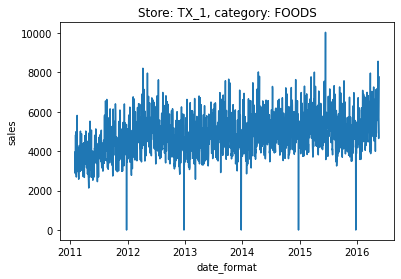

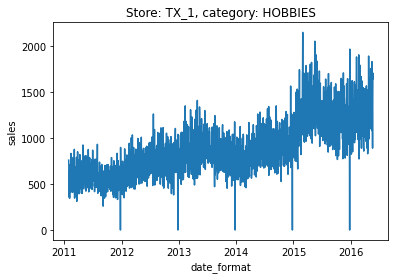

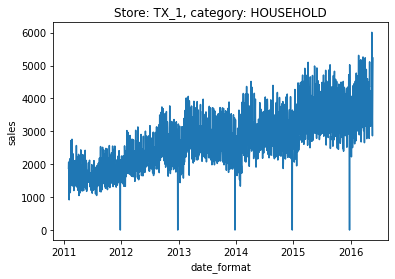

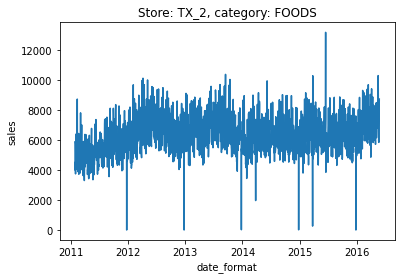

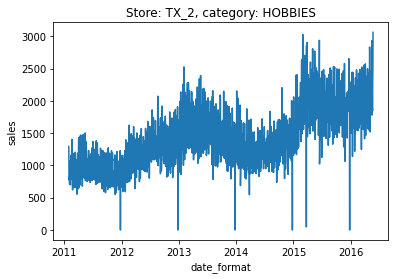

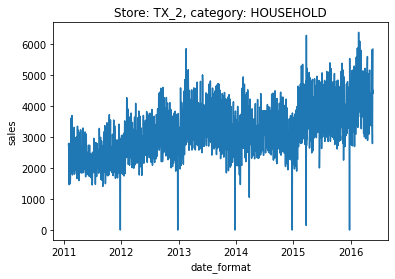

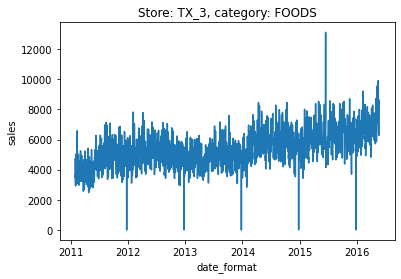

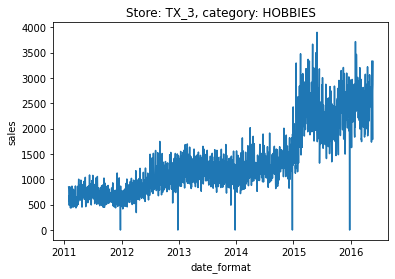

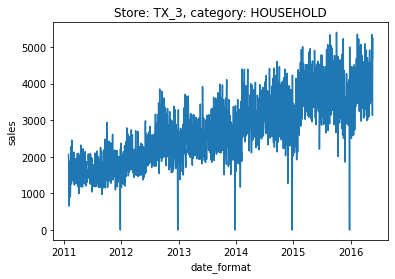

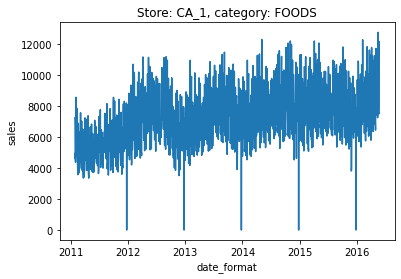

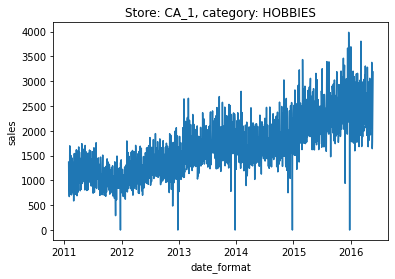

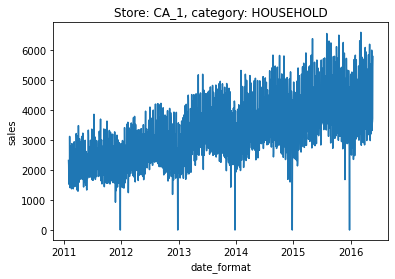

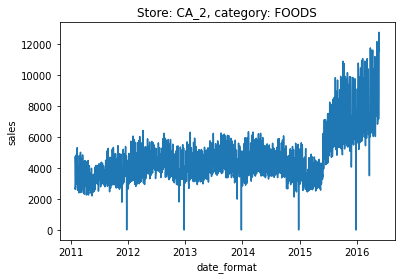

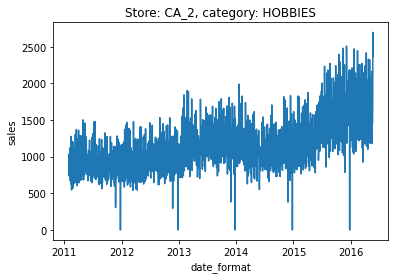

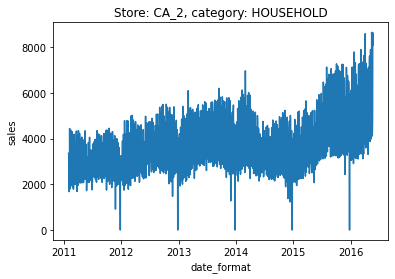

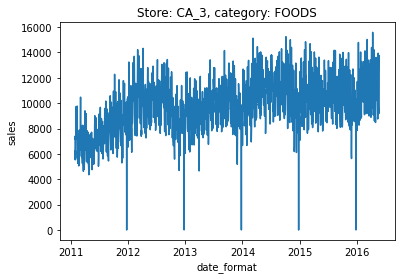

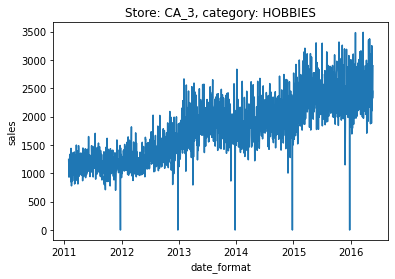

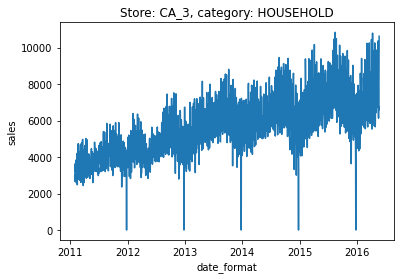

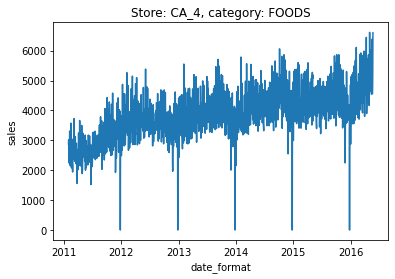

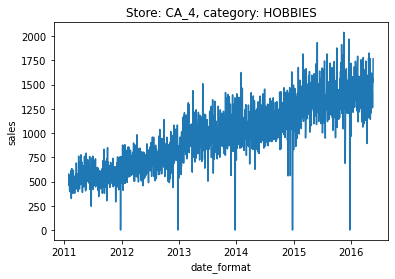

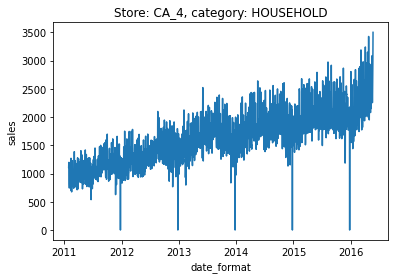

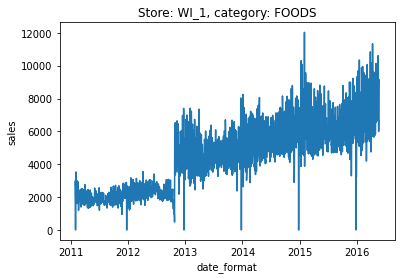

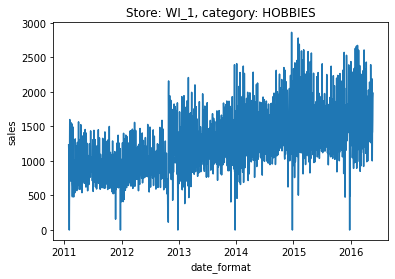

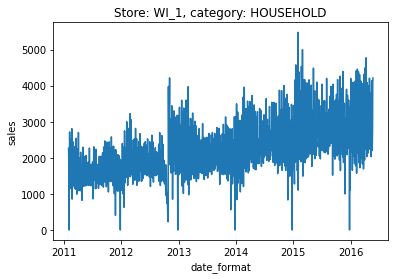

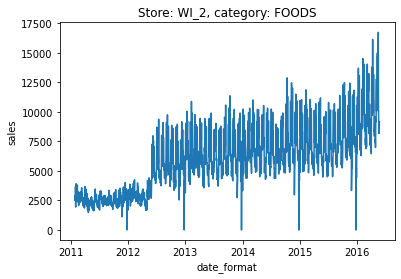

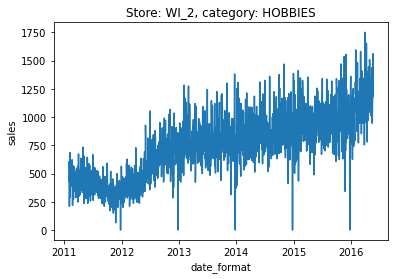

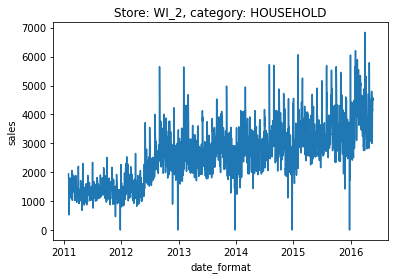

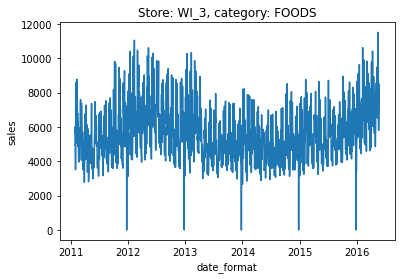

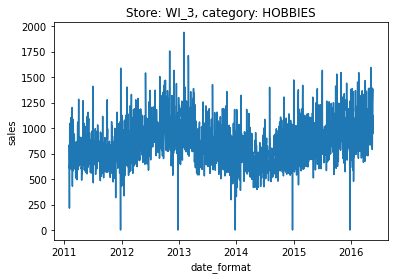

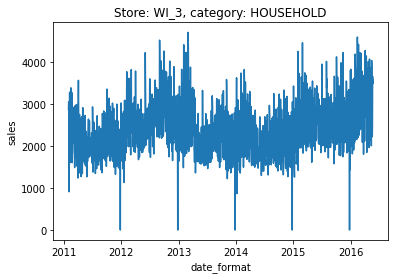

In [15]:
for store in df['store_id'].unique():
    for cat in df['cat_id'].unique():
        subset = df[(df['cat_id']==cat) & (df['store_id']==store)]
        plt.figure()
        sns.lineplot(x=subset['date_format'], y=subset['sales'], ).set(title=f"Store: {store}, category: {cat}")

Overall, the sales of foods are the most stable over time (which is understandable). There appears to be seasonality (regular patterns e.g. for the same month every year) as well as cyclicalty (irregular patterns, presumably governed by changes in the local economy). There are clear outliers, most which appear to be due to Christmas store closures as sales are zero in those periods. A number of series have clear breaks in their means or trends (TX_3 - hoobies, CA_2 - all categories, WI_1 - foods) or breaks due to change in the mean and the change in volatility (WI_2 - all categories).

In [16]:
# Close matplotlib plots to save memory
plt.close('all')

Note that it is best to mark outliers through a separate variable, then investigate them, and only then set them to NaN. Otherwise there is a risk of setting them to NaN and not being able to undo the action, as well as not being able to investigate.

Two measures of outliers are taken: before detrending and after detrending.

In [17]:
# First, we create outlier values, which are set to zero for all values

# Outlier indicator before detrending
df['outlier'] = 0

# Outlier indicator after detrending
df['outlier_detr'] = 0

# We replace Outliers with NaNs if sales data missing
df.loc[df['sales'].isnull(), 'outlier'] = np.nan
df.loc[df['sales'].isnull(), 'outlier_detr'] = np.nan

# Check the number of missing sales values
print(df['sales'].isnull().sum())

0


In [18]:
from scipy import signal

df['sales_detr'] = np.nan

for store in df['store_id'].unique():
    for cat in df['cat_id'].unique():
        ql = df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales"].quantile(0.25)
        qu = df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales"].quantile(0.75)
        iqr = qu-ql
        df.loc[(df['sales']>qu+3*iqr) & (df['cat_id']==cat) & (df['store_id']==store), "outlier"] = 1
        df.loc[(df['sales']<ql-3*iqr) & (df['cat_id']==cat) & (df['store_id']==store), "outlier"] = 1
        print(len(df[(df['cat_id']==cat) & (df['store_id']==store) & (df["outlier"]==1)]))
        
        df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales_detr"] = signal.detrend(df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales"])
        ql = df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales_detr"].quantile(0.25)
        qu = df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales_detr"].quantile(0.75)
        iqr = qu-ql
        df.loc[(df['sales_detr']>qu+3*iqr) & (df['cat_id']==cat) & (df['store_id']==store), "outlier_detr"] = 1
        df.loc[(df['sales_detr']<ql-3*iqr) & (df['cat_id']==cat) & (df['store_id']==store), "outlier_detr"] = 1
        
        print(len(df[(df['cat_id']==cat) & (df['store_id']==store) & (df["outlier_detr"]==1)]))

1
4
0
5
0
3
6
5
0
3
0
4
1
5
0
6
0
3
0
0
0
4
0
1
20
9
1
2
0
0
5
5
0
4
0
4
5
5
0
5
0
7
0
5
0
2
1
2
0
1
0
3
0
6
0
0
1
1
0
0


In [19]:
from scipy import signal

df['sales_detr'] = np.nan

for store in df['store_id'].unique():
    for cat in df['cat_id'].unique():
        ql = df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales"].quantile(0.25)
        qu = df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales"].quantile(0.75)
        iqr = qu-ql
        df.loc[(df['sales']>qu+3*iqr) & (df['cat_id']==cat) & (df['store_id']==store), "outlier"] = 1
        df.loc[(df['sales']<ql-3*iqr) & (df['cat_id']==cat) & (df['store_id']==store), "outlier"] = 1
        print(len(df[(df['cat_id']==cat) & (df['store_id']==store) & (df["outlier"]==1)]))
        
        df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales_detr"] = signal.detrend(df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales"])
        ql = df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales_detr"].quantile(0.25)
        qu = df.loc[(df['cat_id']==cat) & (df['store_id']==store), "sales_detr"].quantile(0.75)
        iqr = qu-ql
        df.loc[(df['sales_detr']>qu+3*iqr) & (df['cat_id']==cat) & (df['store_id']==store), "outlier_detr"] = 1
        df.loc[(df['sales_detr']<ql-3*iqr) & (df['cat_id']==cat) & (df['store_id']==store), "outlier_detr"] = 1
        
        print(len(df[(df['cat_id']==cat) & (df['store_id']==store) & (df["outlier_detr"]==1)]))

1
4
0
5
0
3
6
5
0
3
0
4
1
5
0
6
0
3
0
0
0
4
0
1
20
9
1
2
0
0
5
5
0
4
0
4
5
5
0
5
0
7
0
5
0
2
1
2
0
1
0
3
0
6
0
0
1
1
0
0


#### Plotting Potential Outliers

In [20]:
# Create a variable which will be used for indicating anomalous observations

df['anomalies'] = df['sales']*df['outlier']
df['anomalies_detr'] = df['sales']*df['outlier_detr']

df.tail(10)

,date_format,date,store_id,cat_id,sales,outlier,outlier_detr,sales_detr,anomalies,anomalies_detr
58220,2016-05-22,2016-05-22,CA_4,HOUSEHOLD,3499.97,0.0,1.0,1219.933856,0.0,3499.97
58221,2016-05-22,2016-05-22,WI_1,FOODS,9137.95,0.0,0.0,1800.049438,0.0,0.00
58222,2016-05-22,2016-05-22,WI_1,HOBBIES,1981.67,0.0,0.0,322.254116,0.0,0.00
58223,2016-05-22,2016-05-22,WI_1,HOUSEHOLD,4213.33,0.0,0.0,1299.782567,0.0,0.00
58224,2016-05-22,2016-05-22,WI_2,FOODS,9140.79,0.0,0.0,-424.392872,0.0,0.00
58225,2016-05-22,2016-05-22,WI_2,HOBBIES,1181.54,0.0,0.0,49.131547,0.0,0.00
58226,2016-05-22,2016-05-22,WI_2,HOUSEHOLD,4499.18,0.0,0.0,651.984834,0.0,0.00
58227,2016-05-22,2016-05-22,WI_3,FOODS,8485.18,0.0,0.0,2783.239587,0.0,0.00
58228,2016-05-22,2016-05-22,WI_3,HOBBIES,1380.77,0.0,0.0,472.854204,0.0,0.00
58229,2016-05-22,2016-05-22,WI_3,HOUSEHOLD,3566.90,0.0,0.0,952.831175,0.0,0.00


In [21]:
# In the code below we need to set anomalies to NaN based on outliers, since some anomalies of 0 are 0 because sales are 0 on those dates
df.loc[df['outlier']==0, 'anomalies']=np.nan
df.loc[df['outlier_detr']==0, 'anomalies_detr']=np.nan

df.tail(10)

,date_format,date,store_id,cat_id,sales,outlier,outlier_detr,sales_detr,anomalies,anomalies_detr
58220,2016-05-22,2016-05-22,CA_4,HOUSEHOLD,3499.97,0.0,1.0,1219.933856,NaN,3499.97
58221,2016-05-22,2016-05-22,WI_1,FOODS,9137.95,0.0,0.0,1800.049438,NaN,NaN
58222,2016-05-22,2016-05-22,WI_1,HOBBIES,1981.67,0.0,0.0,322.254116,NaN,NaN
58223,2016-05-22,2016-05-22,WI_1,HOUSEHOLD,4213.33,0.0,0.0,1299.782567,NaN,NaN
58224,2016-05-22,2016-05-22,WI_2,FOODS,9140.79,0.0,0.0,-424.392872,NaN,NaN
58225,2016-05-22,2016-05-22,WI_2,HOBBIES,1181.54,0.0,0.0,49.131547,NaN,NaN
58226,2016-05-22,2016-05-22,WI_2,HOUSEHOLD,4499.18,0.0,0.0,651.984834,NaN,NaN
58227,2016-05-22,2016-05-22,WI_3,FOODS,8485.18,0.0,0.0,2783.239587,NaN,NaN
58228,2016-05-22,2016-05-22,WI_3,HOBBIES,1380.77,0.0,0.0,472.854204,NaN,NaN
58229,2016-05-22,2016-05-22,WI_3,HOUSEHOLD,3566.90,0.0,0.0,952.831175,NaN,NaN


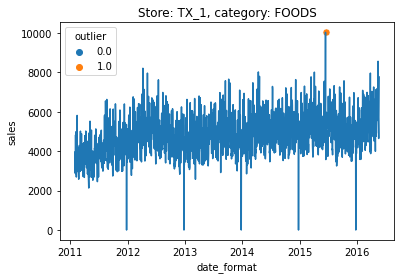

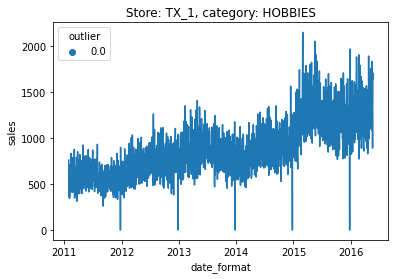

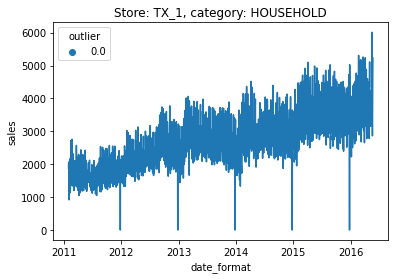

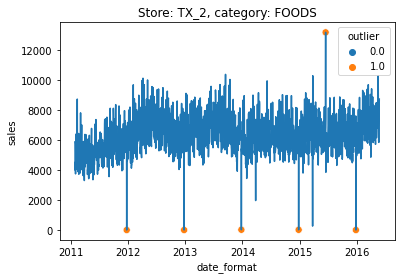

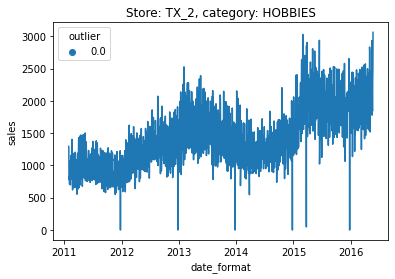

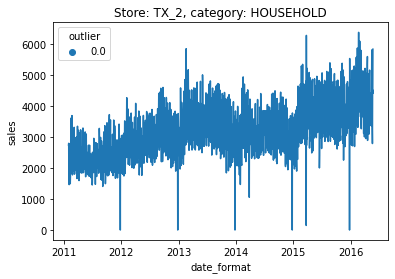

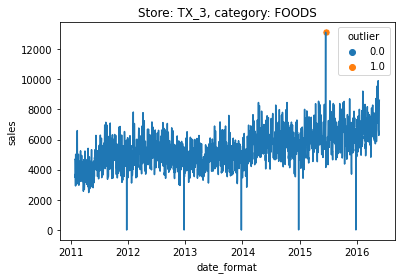

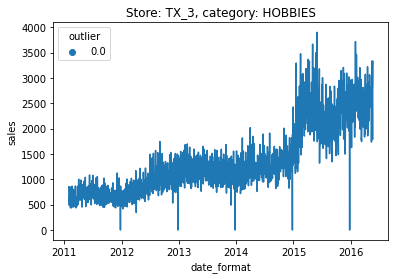

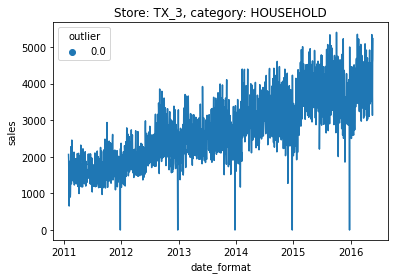

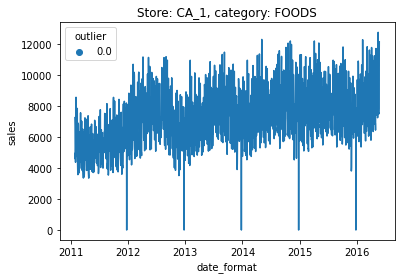

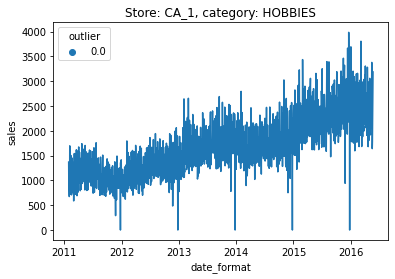

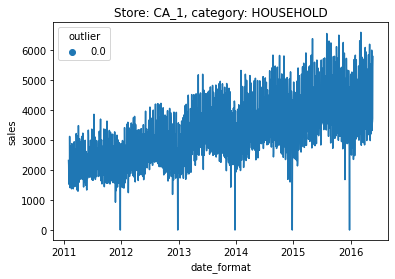

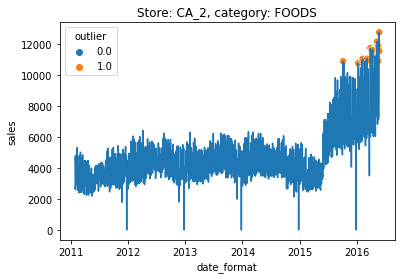

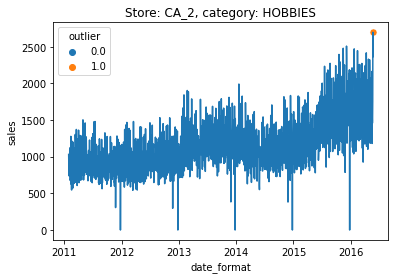

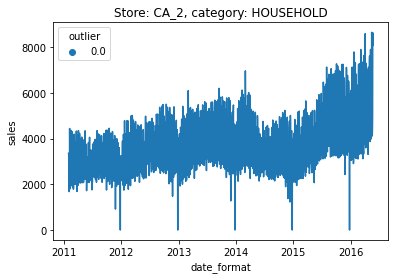

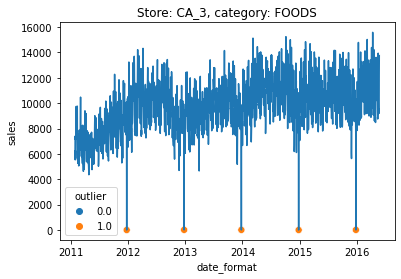

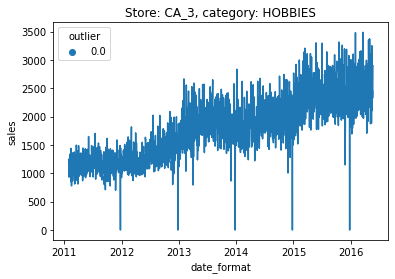

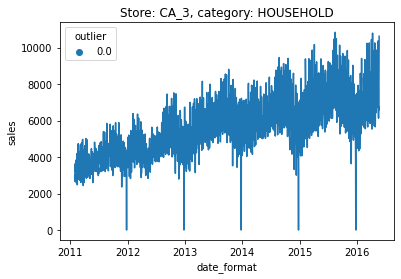

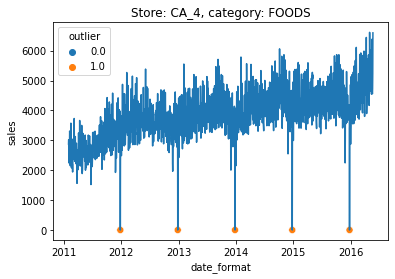

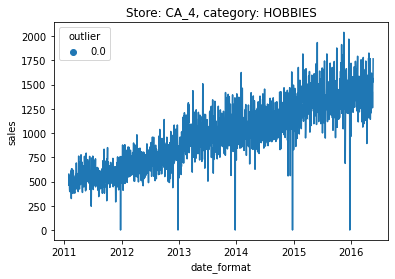

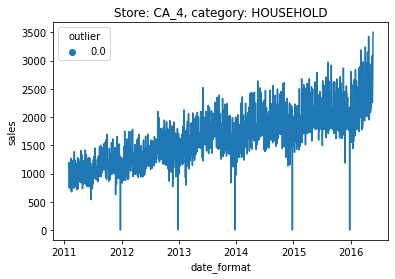

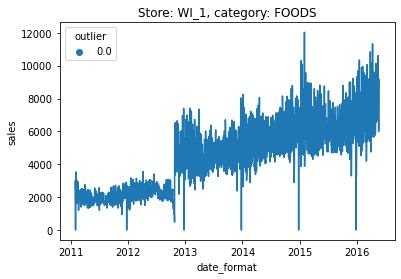

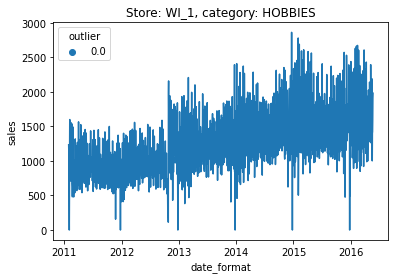

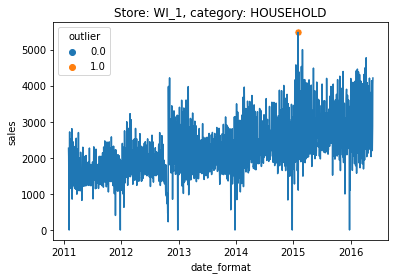

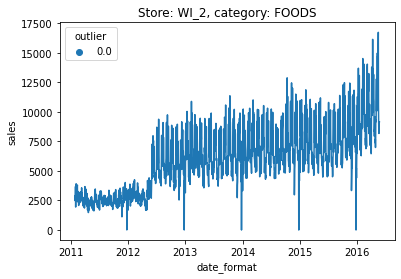

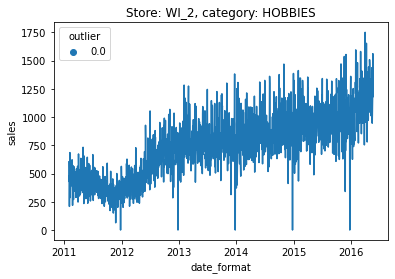

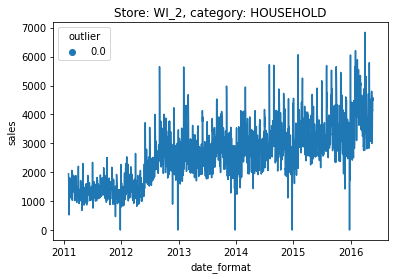

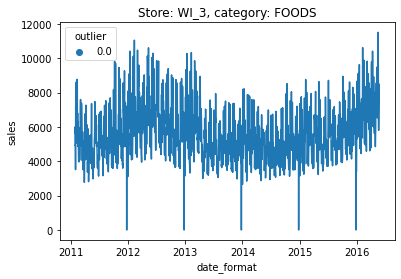

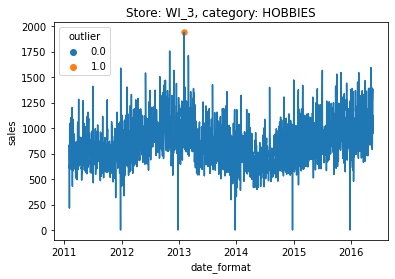

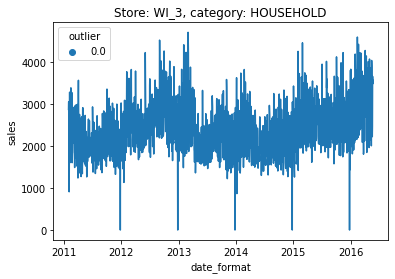

In [22]:
for store in df['store_id'].unique():
    for cat in df['cat_id'].unique():
        subset = df[(df['cat_id']==cat) & (df['store_id']==store)]
        plt.figure()
        sns.lineplot(x=subset['date_format'], y=subset['sales'], ).set(title=f"Store: {store}, category: {cat}")
        sns.scatterplot(x=subset['date_format'], y=subset['anomalies'], s=50, hue=subset['outlier'])

In [23]:
plt.close('all')

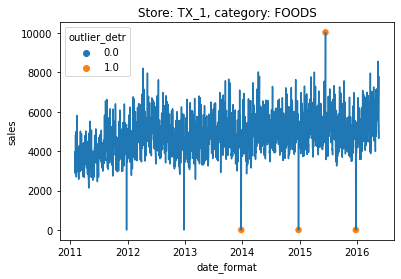

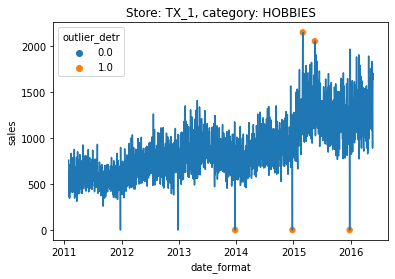

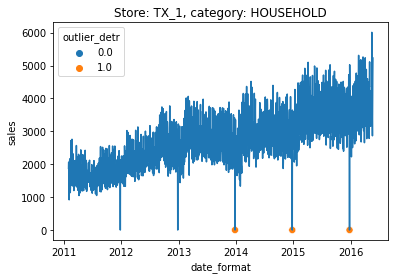

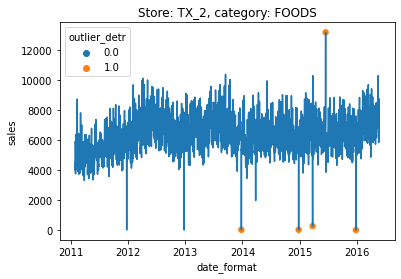

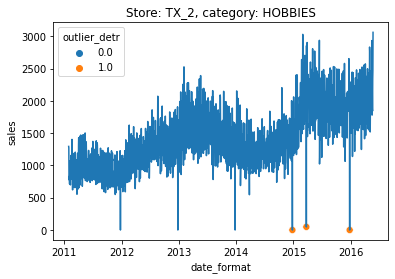

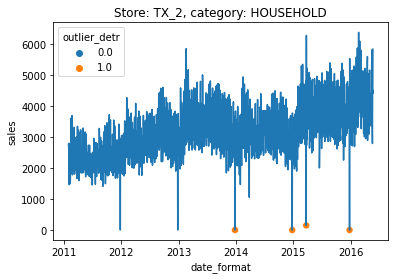

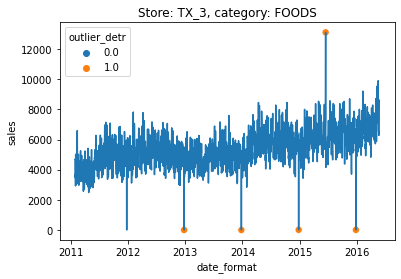

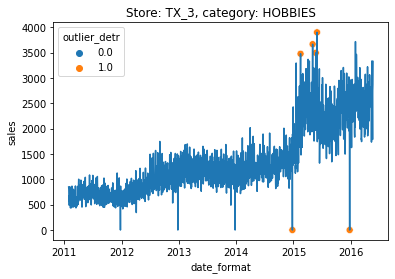

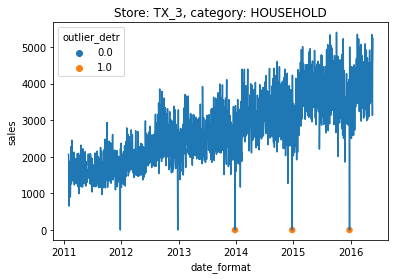

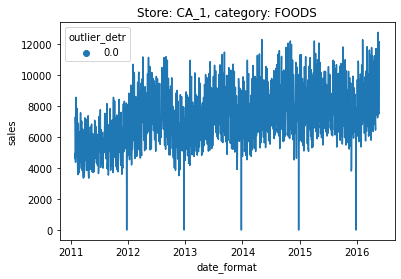

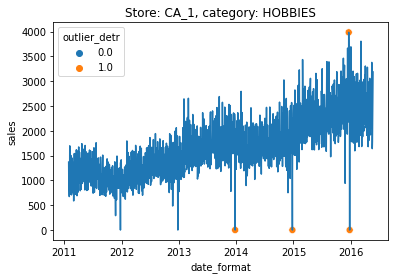

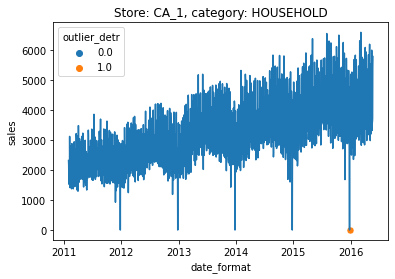

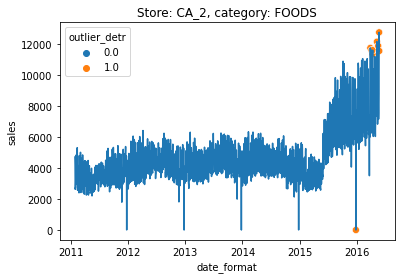

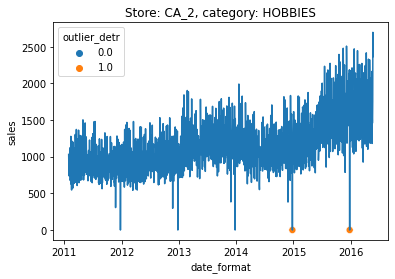

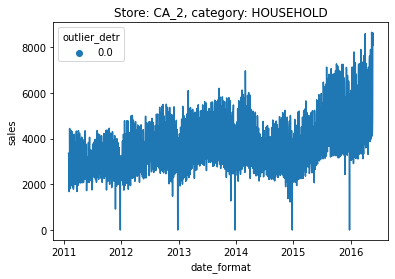

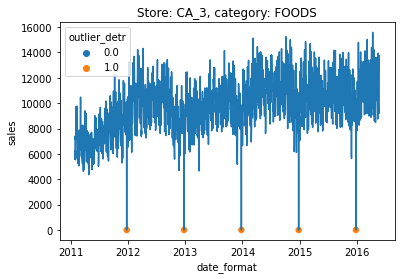

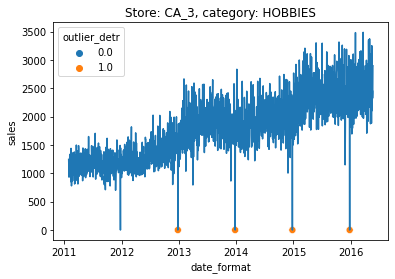

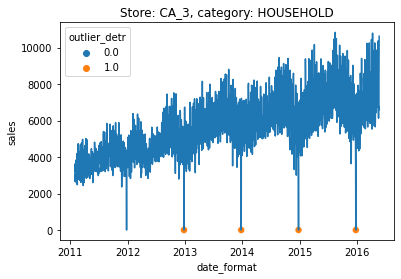

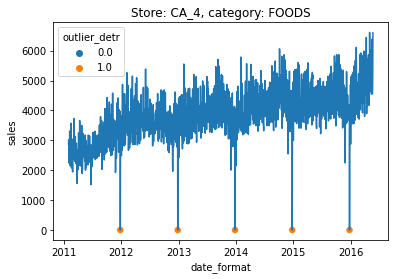

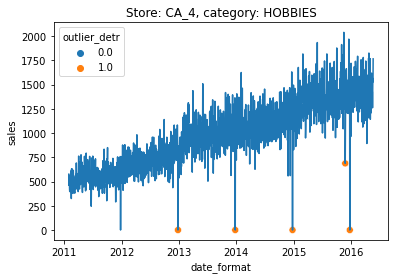

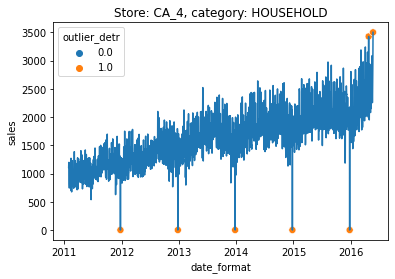

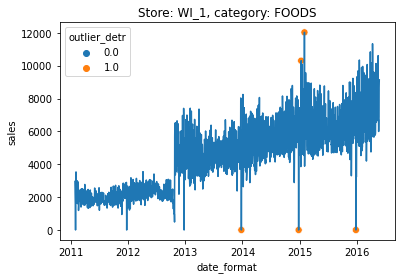

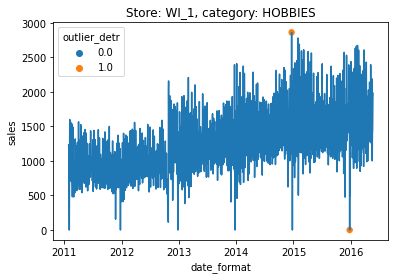

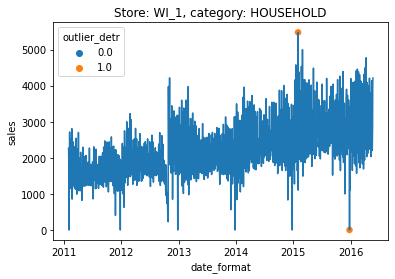

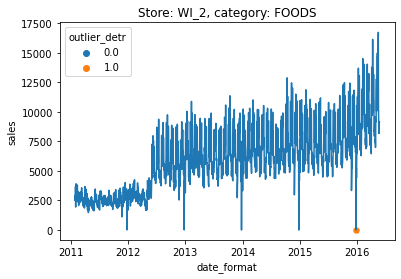

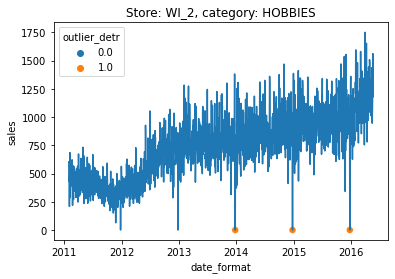

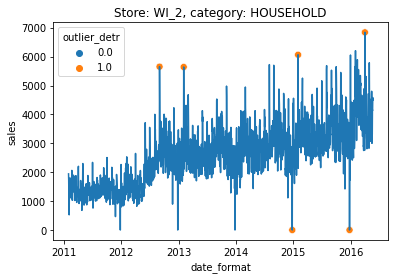

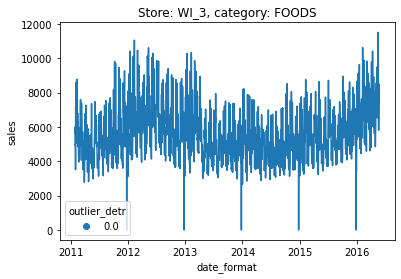

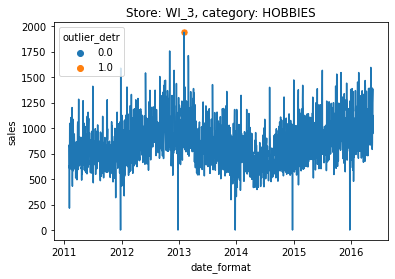

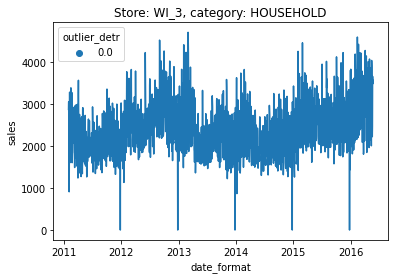

In [24]:
for store in df['store_id'].unique():
    for cat in df['cat_id'].unique():
        subset = df[(df['cat_id']==cat) & (df['store_id']==store)]
        plt.figure()
        sns.lineplot(x=subset['date_format'], y=subset['sales'], ).set(title=f"Store: {store}, category: {cat}")
        sns.scatterplot(x=subset['date_format'], y=subset['anomalies_detr'], s=50, hue=subset['outlier_detr'])

In [25]:
plt.close('all')

In the case out outliers based on the original data, the zero values do not appear to be picked up, except for CA_3: FOODS, CA_4:FOODS and TX_2:FOODS. In the case of detrended data, only some of the zeroes within a given graph are picked up, while values that may appear to be "less" outlying in the upper part of the graph are picked up as outliers. This is likely due to the fact that the linear trend in scipy is fitted on the basis of least squares, which is itself going to be affected by the zeroes since the large distance of the zeroes from the trend line is amplified in the square-based loss function. We can investigate it by fitting and drawing an OLS line through the data.

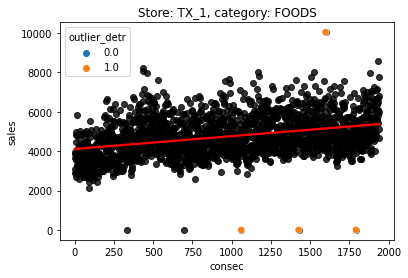

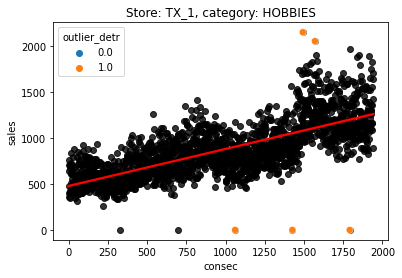

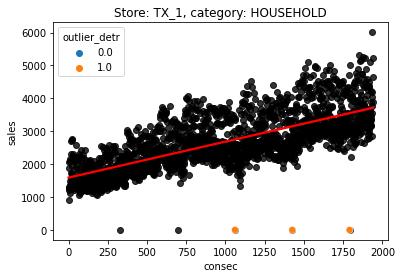

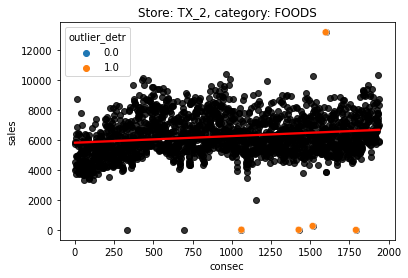

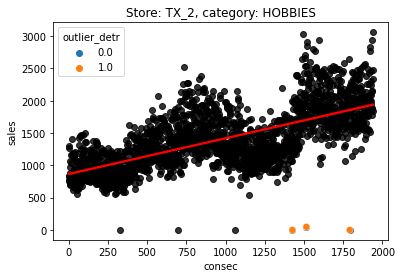

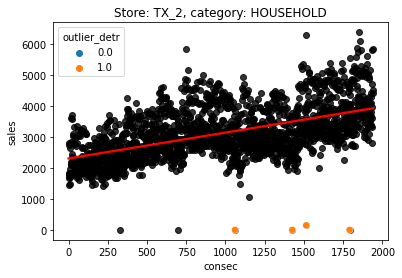

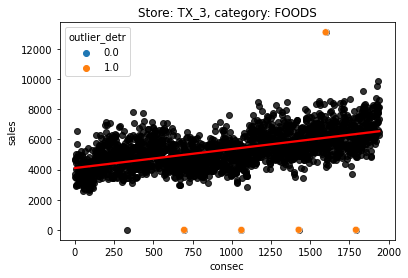

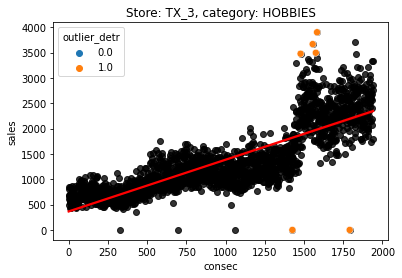

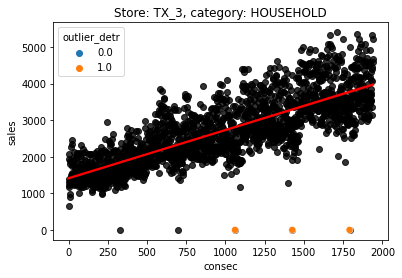

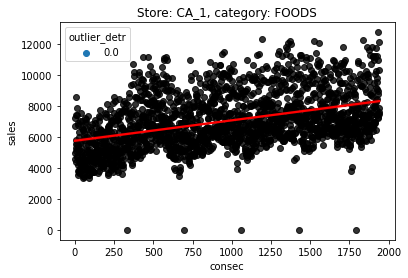

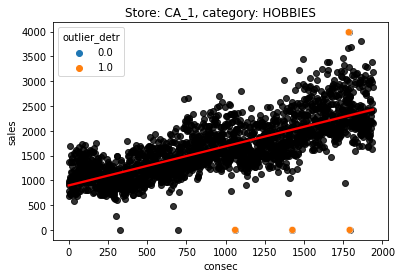

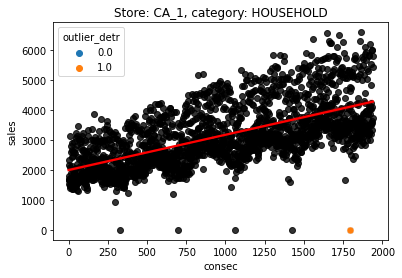

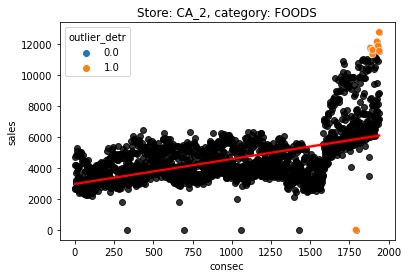

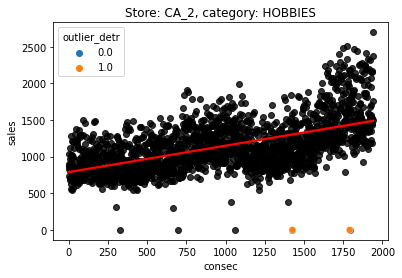

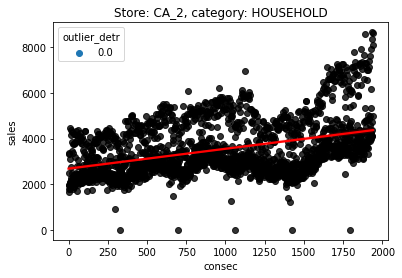

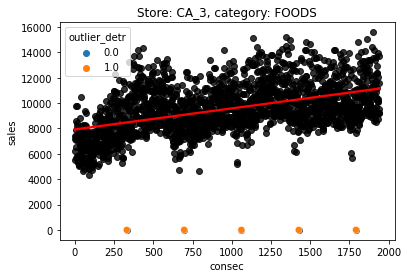

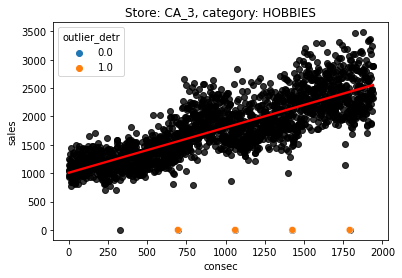

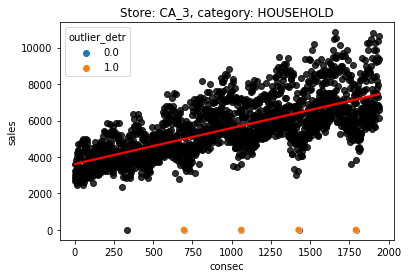

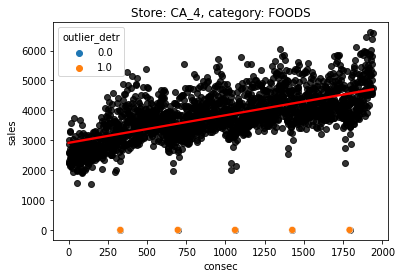

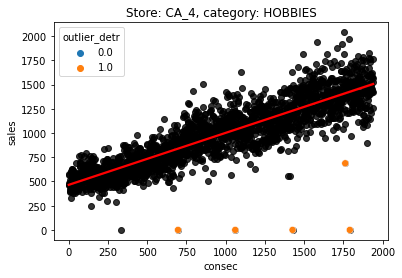

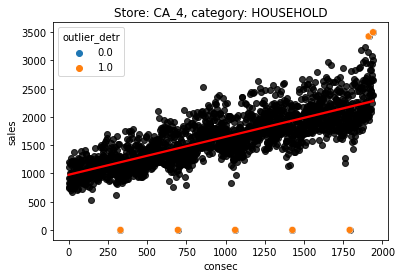

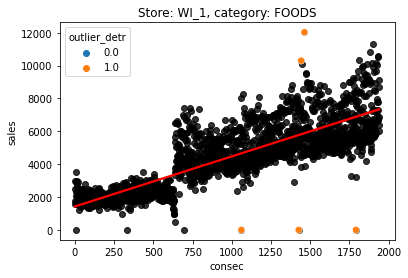

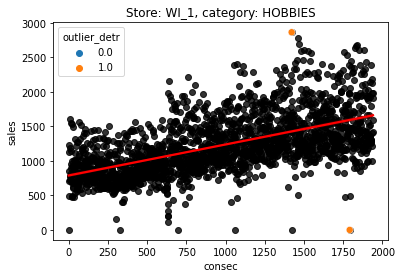

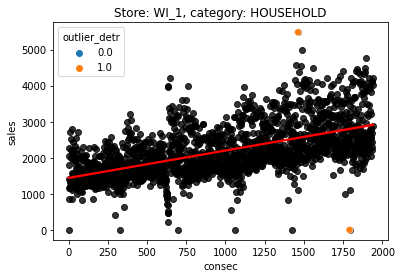

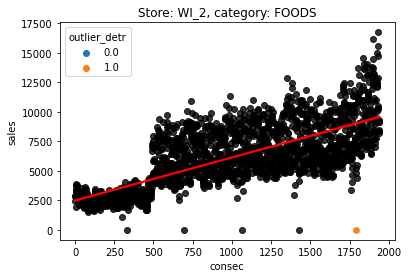

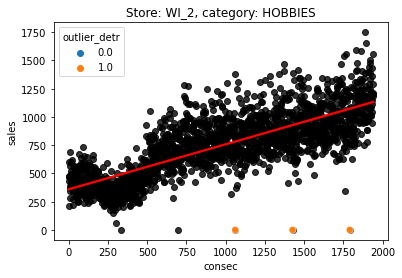

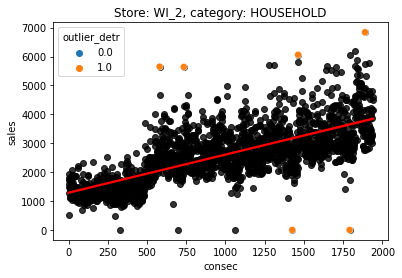

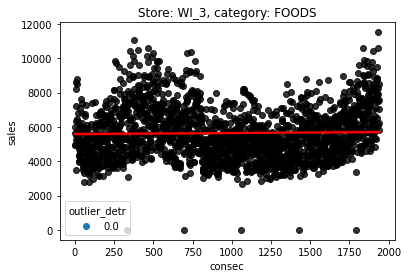

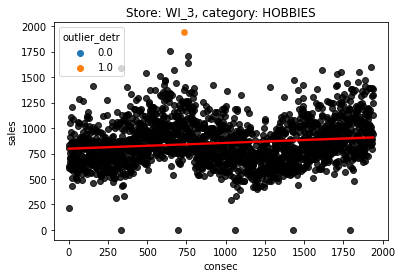

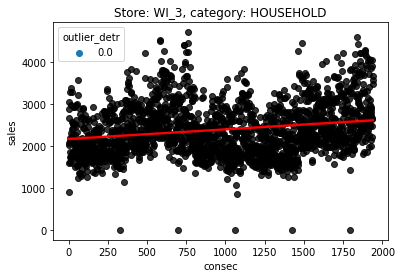

In [26]:
for store in df['store_id'].unique():
    for cat in df['cat_id'].unique():
        subset = df[(df['cat_id']==cat) & (df['store_id']==store)].copy() # We need a copy because we will modify the data
        subset['consec'] = range(0, len(subset))
        
        plt.figure()
        #sns.lineplot(x=subset['consec'], y=subset['sales'], ).set(title=f"Store: {store}, category: {cat}")
        sns.regplot(x=subset['consec'], y=subset['sales'], scatter_kws={"color": "black"}, line_kws={"color": "red"})
        sns.scatterplot(x=subset['consec'], y=subset['anomalies_detr'], s=50, hue=subset['outlier_detr']).set(title=f"Store: {store}, category: {cat}")

In [27]:
plt.close('all')

Indeed, wecan clearly see how the trand line results in some zeroes not being picked up.

We still need to decide whether we wish to interpolate the values of those observations which we marked as outliers, or whether we wish to keep them as they are. In particular, the periodic nature of the zeros indicates that they may occur on the same day of the year every year (e.g. Christmas). This will be verified below. In such case, there are two approaches we may wish to take: either to interpolate the values of the zeroes, or to leave them in, but create an indicator variable in our model that correspond to the specific calendar date that the zero sales arise on every year, and then include that indicator varible in our analysis.

Another case in which we may wish to unmark observations from the outlier list is CA_2: FOODS. The higher sales in the later part of the sample are picked up as being outliers, but this is due to the fact that there is a significant break in the mean of the series, which is not properly modelled by the linear trend; as well as a possible break in the trend (the slope of the trend line is likely to be higher post-berak). As a result, while the observations do not appear to be outlying with respect to their post-break mean and trend, they do come up as outliers based on the fitted trend.

Other than the above zeroes and CA_2:FOODS, all other observations marked as outliers can reasonably be interpreted as outliers.

In [28]:
# Investigating the dates corresponding to zeroes

df.loc[df['sales']==0, 'date_format']

142     2011-02-02
143     2011-02-02
9900    2011-12-25
9901    2011-12-25
9902    2011-12-25
           ...    
53752   2015-12-25
53755   2015-12-25
53756   2015-12-25
53758   2015-12-25
53759   2015-12-25
Name: date_format, Length: 125, dtype: datetime64[ns]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58230 entries, 0 to 58229
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_format     58230 non-null  datetime64[ns]
 1   date            58230 non-null  object        
 2   store_id        58230 non-null  object        
 3   cat_id          58230 non-null  object        
 4   sales           58230 non-null  float64       
 5   outlier         58230 non-null  float64       
 6   outlier_detr    58230 non-null  float64       
 7   sales_detr      58230 non-null  float64       
 8   anomalies       41 non-null     float64       
 9   anomalies_detr  104 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 4.9+ MB


In [30]:
df['xmas'] = 0
df.loc[(df['date_format'].dt.month==12) & (df['date_format'].dt.day==25), 'xmas'] = 1

In [31]:
df[df['xmas']==1].head(10)

,date_format,date,store_id,cat_id,sales,outlier,outlier_detr,sales_detr,anomalies,anomalies_detr,xmas
9900,2011-12-25,2011-12-25,TX_1,FOODS,0.00,0.0,0.0,-4325.732392,NaN,NaN,1
9901,2011-12-25,2011-12-25,TX_1,HOBBIES,0.00,0.0,0.0,-611.129407,NaN,NaN,1
9902,2011-12-25,2011-12-25,TX_1,HOUSEHOLD,0.00,0.0,0.0,-1951.193268,NaN,NaN,1
9903,2011-12-25,2011-12-25,TX_2,FOODS,0.00,1.0,0.0,-5962.190850,0.0,NaN,1
9904,2011-12-25,2011-12-25,TX_2,HOBBIES,0.00,0.0,0.0,-1048.308863,NaN,NaN,1
9905,2011-12-25,2011-12-25,TX_2,HOUSEHOLD,0.00,0.0,0.0,-2582.284257,NaN,NaN,1
9906,2011-12-25,2011-12-25,TX_3,FOODS,3.36,0.0,0.0,-4517.285430,NaN,NaN,1
9907,2011-12-25,2011-12-25,TX_3,HOBBIES,0.00,0.0,0.0,-701.680197,NaN,NaN,1
9908,2011-12-25,2011-12-25,TX_3,HOUSEHOLD,0.00,0.0,0.0,-1847.268456,NaN,NaN,1
9909,2011-12-25,2011-12-25,CA_1,FOODS,0.00,0.0,0.0,-6179.663277,NaN,NaN,1


In [32]:
df.head(10)

,date_format,date,store_id,cat_id,sales,outlier,outlier_detr,sales_detr,anomalies,anomalies_detr,xmas
0,2011-01-29,2011-01-29,TX_1,FOODS,3950.35,0.0,0.0,-160.500963,NaN,NaN,0
1,2011-01-29,2011-01-29,TX_1,HOBBIES,759.99,0.0,0.0,281.698772,NaN,NaN,0
2,2011-01-29,2011-01-29,TX_1,HOUSEHOLD,1876.34,0.0,0.0,286.079770,NaN,NaN,0
3,2011-01-29,2011-01-29,TX_2,FOODS,5877.90,0.0,0.0,61.550680,NaN,NaN,0
4,2011-01-29,2011-01-29,TX_2,HOBBIES,1294.04,0.0,0.0,428.252098,NaN,NaN,0
5,2011-01-29,2011-01-29,TX_2,HOUSEHOLD,2743.84,0.0,0.0,437.122289,NaN,NaN,0
6,2011-01-29,2011-01-29,TX_3,FOODS,4681.27,0.0,0.0,575.561444,NaN,NaN,0
7,2011-01-29,2011-01-29,TX_3,HOBBIES,850.81,0.0,0.0,485.888016,NaN,NaN,0
8,2011-01-29,2011-01-29,TX_3,HOUSEHOLD,2065.91,0.0,0.0,653.924395,NaN,NaN,0
9,2011-01-29,2011-01-29,CA_1,FOODS,7240.65,0.0,0.0,1494.960186,NaN,NaN,0


In [33]:
# Unmarking outliers
# CA_2:FOODS
df.loc[(df['store_id']=='CA_2') & (df['cat_id']== 'FOODS') & (df['sales']>10000),'outlier_detr'] = 0

# Marking zero values as outliers
df.loc[df['sales']==0,'outlier_detr'] = 1

In [105]:
# Coding observations to NaN if they are outliers

df['sales_fixed'] = df['sales']
df.loc[df['outlier_detr']==1, 'sales_fixed'] = np.nan

In [106]:
df.head(10)

,date_format,date,store_id,cat_id,sales,outlier,outlier_detr,sales_detr,anomalies,anomalies_detr,xmas,sales_fixed,store_date
0,2011-01-29,2011-01-29,TX_1,FOODS,3950.35,0.0,0.0,-160.500963,NaN,NaN,0,3950.35,0.0
1,2011-01-29,2011-01-29,TX_1,HOBBIES,759.99,0.0,0.0,281.698772,NaN,NaN,0,759.99,0.0
2,2011-01-29,2011-01-29,TX_1,HOUSEHOLD,1876.34,0.0,0.0,286.079770,NaN,NaN,0,1876.34,0.0
3,2011-01-29,2011-01-29,TX_2,FOODS,5877.90,0.0,0.0,61.550680,NaN,NaN,0,5877.90,0.0
4,2011-01-29,2011-01-29,TX_2,HOBBIES,1294.04,0.0,0.0,428.252098,NaN,NaN,0,1294.04,0.0
5,2011-01-29,2011-01-29,TX_2,HOUSEHOLD,2743.84,0.0,0.0,437.122289,NaN,NaN,0,2743.84,0.0
6,2011-01-29,2011-01-29,TX_3,FOODS,4681.27,0.0,0.0,575.561444,NaN,NaN,0,4681.27,0.0
7,2011-01-29,2011-01-29,TX_3,HOBBIES,850.81,0.0,0.0,485.888016,NaN,NaN,0,850.81,0.0
8,2011-01-29,2011-01-29,TX_3,HOUSEHOLD,2065.91,0.0,0.0,653.924395,NaN,NaN,0,2065.91,0.0
9,2011-01-29,2011-01-29,CA_1,FOODS,7240.65,0.0,0.0,1494.960186,NaN,NaN,0,7240.65,0.0


In [107]:
from scipy.interpolate import interp1d

df['store_date']=np.nan

for store in df['store_id'].unique():
    for cat in df['cat_id'].unique():
        df[(df['store_id']==store) & (df['cat_id']==cat)] =  df[(df['store_id']==store) & (df['cat_id']==cat)].sort_values(by=['date_format'])
        df.loc[(df['store_id']==store) & (df['cat_id']==cat), 'store_date'] = range(0, len(df[(df['store_id']==store) & (df['cat_id']==cat)]))
        
        # Print the number of missing values
        missing = len(df[(df['store_id']==store) & (df['cat_id']==cat) & (df['sales_fixed'].isnull())])
        print(f"Number of missing values for store {store} and category {cat} is: {missing}.")
        
        # Define function inter_fun which interpolates based on a subset of the data for which sales are not missing;
        # this is required for the interp1d function as its behaviour is unpredictable if there are NaN's
        inter_fun = interp1d(x=df.loc[(df['store_id']==store) & (df['cat_id']==cat) & (~df['sales_fixed'].isnull()), 'store_date'],
                             y=df.loc[(df['store_id']==store) & (df['cat_id']==cat) & (~df['sales_fixed'].isnull()), 'sales_fixed'], fill_value='extrapolate')
        
        # Replace values of 'sales_fixed' with interpolated values 
        df.loc[(df['store_id']==store) & (df['cat_id']==cat)  & (df['sales_fixed'].isnull()), 'sales_fixed'] = inter_fun(df.loc[(df['store_id']==store) & (df['cat_id']==cat) & (df['sales_fixed'].isnull()), 'store_date'])
        
        # Checking whether the number of missing values has changed
        missing = len(df[(df['store_id']==store) & (df['cat_id']==cat) & (df['sales_fixed'].isnull())])
        print(f"Number of missing values for store {store} and category {cat} is: {missing}.")
        
        # Checking that there are no other changes
        diff = len(df[(df['store_id']==store) & (df['cat_id']==cat) & (df['sales_fixed'] != df['sales'])])
        print(f"Number of values of sales and sales_fixed for store {store} and category {cat} which are different is: {diff}.")

Number of missing values for store TX_1 and category FOODS is: 6.
Number of missing values for store TX_1 and category FOODS is: 0.
Number of values of sales and sales_fixed for store TX_1 and category FOODS which are different is: 6.
Number of missing values for store TX_1 and category HOBBIES is: 7.
Number of missing values for store TX_1 and category HOBBIES is: 0.
Number of values of sales and sales_fixed for store TX_1 and category HOBBIES which are different is: 7.
Number of missing values for store TX_1 and category HOUSEHOLD is: 5.
Number of missing values for store TX_1 and category HOUSEHOLD is: 0.
Number of values of sales and sales_fixed for store TX_1 and category HOUSEHOLD which are different is: 5.
Number of missing values for store TX_2 and category FOODS is: 7.
Number of missing values for store TX_2 and category FOODS is: 0.
Number of values of sales and sales_fixed for store TX_2 and category FOODS which are different is: 7.
Number of missing values for store TX_2 an

[Text(0.5, 1.0, 'Store: WI_1, category: HOUSEHOLD')]

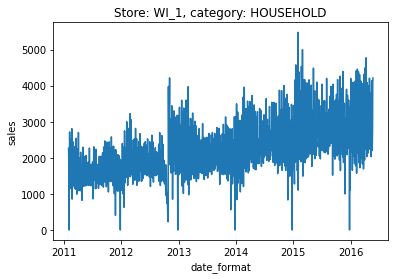

In [109]:
# Visual verification of the outlier interpolation

store = 'WI_1'
cat = 'HOUSEHOLD'

sns.lineplot(x=df.loc[(df['store_id']==store) & (df['cat_id']==cat), 'date_format'], y=df.loc[(df['store_id']==store) & (df['cat_id']==cat), 'sales']).set(title=f"Store: {store}, category: {cat}")

[Text(0.5, 1.0, 'Store: WI_1, category: HOUSEHOLD')]

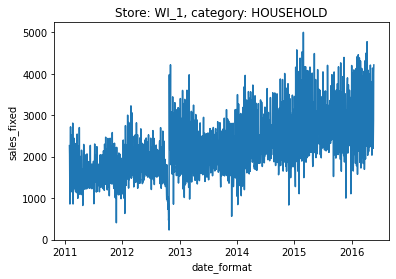

In [110]:
sns.lineplot(x=df.loc[(df['store_id']==store) & (df['cat_id']==cat), 'date_format'], y=df.loc[(df['store_id']==store) & (df['cat_id']==cat), 'sales_fixed']).set(title=f"Store: {store}, category: {cat}")

This all looks good. No suspicious values appear to have been created.

In [111]:
df.to_csv("workflow_files/sales_processed.csv")